In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt
from scipy.stats import gmean

colors = viz.plotting_style()
lin_colors = colors.values()
plt.style.use('style.mpl')

color_order = ['green', 'blue', 'red', 'purple', 'yellow', 'dark_green', 'dark_blue', 'dark_brown']
lin_colors = [colors[c] for c in color_order]

# Code generating Figure 5
Figure 5 shows that the additional conservation law required by autotrophy limits maximum autotrophic growth rates. 
It's a hybrid figure with an illustration added later in Illustrator. 

We use the convex optimization approaches to analyze our unified model. 
To generate optimization results files used here, run "do_optimization_analyses.py".

In [2]:
# Load empirical data on growth rates --
# this file was generated by manual literature review and 
# then running munge/munge_growth_rates.py to annotate. 
fast_growers_df = pd.read_csv('../data/physiology/fastest_growers_4plotting.csv')

# Load modeled auto and heterotroph growth rates from sampling + optimization
# generated by do_optimization_analyses.py
auto_comp_df = pd.read_csv('../output/linear_optimization/auto_sampling.csv')
hetero_comp_df = pd.read_csv('../output/linear_optimization/respiration_sampling_auto_comparison.csv')

# Autotrophic growth rates without the constraint on C_red
auto_comp_C_ext_df = pd.read_csv('../output/linear_optimization/auto_sampling_ext_C.csv')

# Concatentate two dataframes comparing respiration and autotrophic growth rates
# For the main-text figure, focus on one C_red concentration
auto_mask = auto_comp_df['opt.fixed_C_red_mol_gCDW'] == 1e-6
comp_df = pd.concat([auto_comp_df[auto_mask], hetero_comp_df])

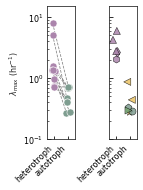

In [3]:
# Panels for the main text figure 5
fig, axs = plt.subplots(ncols=2, figsize=(2.1, 2.75), sharey=True)

# Plot the pairs of growth rates calculated with the same sampled params
# Note: we are neglecting max growth rates that are very low for heterotrophy
# since this is implausible in the first place.
plt.sca(axs[0])
plt.yscale('log')

mask = (hetero_comp_df.lambda_hr > 0.05)
idxs = hetero_comp_df[mask].index[:10]
auto_examples = auto_comp_df.iloc[idxs].copy()
np.random.seed(23)
auto_examples['x_pos'] = 1 + np.random.normal(0, 0.07, size=10)
hetero_examples = hetero_comp_df.iloc[idxs].copy()
hetero_examples['x_pos'] = 0 + np.random.normal(0, 0.07, size=10)

sns.scatterplot(data=auto_examples, x='x_pos', y='lambda_hr', color=colors['dark_green'], s=50)
sns.scatterplot(data=hetero_examples, x='x_pos', y='lambda_hr', color=colors['purple'], s=50)
for i in range(10):
    auto_ex = auto_examples.iloc[i]
    hetero_ex = hetero_examples.iloc[i]
    plt.plot([hetero_ex.x_pos, auto_ex.x_pos], [hetero_ex.lambda_hr, auto_ex.lambda_hr],
             color='grey', lw=0.75, zorder=0, ls='--')

plt.xticks([0, 1], ['heterotroph', 'autotroph'], ha='right', rotation=45)
#plt.xticks([])
plt.xlim(-0.5, 1.5)
plt.xlabel('')
#plt.title('Modeled')
plt.ylabel('$\lambda_{\mathrm{max}}$ (hr$^{-1}$)')

plt.sca(axs[1])
plt.yscale('log')
for short_name, gdf in fast_growers_df.groupby('short_name'):
    plt.scatter(gdf.xpos.values, gdf.growth_rate_hr.values,
                color=gdf.color.values, marker=gdf.marker.values[0],
                s=50, lw=0.5, edgecolor='k', alpha=0.85)

plt.xlabel('')
#plt.ylabel('$\lambda_{\mathrm{max}}$ (hr$^{-1}$)')
plt.xticks([0,1], 'heterotroph,autotroph'.split(','), ha='right', rotation=45)
#plt.xticks([])
plt.ylim(0.1, 15)
plt.xlim(-0.5, 1.5)
#plt.title('Measured')

plt.tight_layout()
plt.subplots_adjust(wspace=1.2)
plt.savefig('../output/Fig5_BC.pdf', facecolor='w', dpi=300)

1e-12
1e-06
0.1


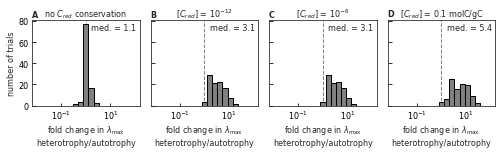

In [4]:
# Supplementary figure comparing the fold change in growth rate
# as a function of the assumed C_red concentration
fig, axs = plt.subplots(figsize=(7.08, 2.25), ncols=4, sharey=True)

plt.sca(axs[0])
data = np.vstack([auto_comp_C_ext_df.lambda_hr.values, hetero_comp_df.lambda_hr.values]).T
auto_comp_lambdas = pd.DataFrame(data, columns='auto_lambda_hr,hetero_lambda_hr'.split(','))
auto_comp_lambdas['fc'] = auto_comp_lambdas.hetero_lambda_hr / auto_comp_lambdas.auto_lambda_hr
plt.ylabel('number of trials')
median_fc = auto_comp_lambdas.fc.median()
plt.text(0.97, 0.97, 'med. = {0:.1f}'.format(median_fc),
         ha='right', va='top', fontsize=8, transform=axs[0].transAxes)


# Plot the distribution of the fold change in growth rate
bins = np.logspace(-2, 2, 20)
plt.xscale('log')
plt.hist(auto_comp_lambdas.fc, bins=bins, color='grey', edgecolor='k')

# extract the pairs of growth rates calculated with the same sampled params
for i, (fixed_C_red, gdf) in enumerate(auto_comp_df.groupby('opt.fixed_C_red_mol_gCDW')):
   data = np.vstack([gdf.lambda_hr.values, hetero_comp_df.lambda_hr.values]).T
   auto_comp_lambdas = pd.DataFrame(data, columns='auto_lambda_hr,hetero_lambda_hr'.split(','))
   auto_comp_lambdas['fc'] = auto_comp_lambdas.hetero_lambda_hr / auto_comp_lambdas.auto_lambda_hr

   plt.sca(axs[i+1])
   print(fixed_C_red)

   # Plot the distribution of the fold change in growth rate
   plt.xscale('log')
   plt.hist(auto_comp_lambdas.fc, bins=bins, color='grey', edgecolor='k')
   median_fc = auto_comp_lambdas.fc.median()
   plt.text(0.97, 0.97, 'med. = {0:.1f}'.format(median_fc),
            ha='right', va='top', fontsize=8, transform=axs[i+1].transAxes)


plt.title('no $C_{red}$ conservation')
titles = ['no $C_{red}$ conservation',
          '[$C_{red}$] = $10^{-12}$',
          '[$C_{red}$] = $10^{-6}$',
          '[$C_{red}$] = $0.1$ molC/gC',
          ]
panels = 'ABCD'
for i, ax in enumerate(axs):
   plt.sca(ax)
   plt.xlabel('fold change in $\lambda_{\mathrm{max}}$\nheterotrophy/autotrophy')
   plt.title(titles[i])
   plt.title(panels[i], loc='left', fontweight='bold')
   plt.axvline(1, ls='--', color='grey', lw=1, zorder=-10)

plt.tight_layout()
plt.savefig('../output/FigSX_autotrophy_constraint.png', facecolor='white', dpi=300)
plt.show()


In [5]:
# Making a supplementary figure about constraints on a simple model of fermentation. 
# The CSV files loaded here were generated by do_optimization_analyses.py.

# Load modeled fermentation vs. respiration growth rates from sampling + optimization
ferm_comp_df = pd.read_csv('../output/linear_optimization/ferm_sampling.csv')
resp_comp_df = pd.read_csv('../output/linear_optimization/respiration_sampling_ferm_comparison.csv')

# Pick out one concentration
fixed_C_ox = 1.e-06
ferm_comp_one_C_ox_df = ferm_comp_df[ferm_comp_df['opt.fixed_C_ox_mol_gCDW'] == fixed_C_ox]

# Fermentative growth rates without the constraint on C_red
ferm_comp_C_ext_df = pd.read_csv('../output/linear_optimization/ferm_sampling_ext_C.csv')

# Fermentative growth rates with a bit extra ATP
ferm_comp_ext_C_more_ATP_df = pd.read_csv('../output/linear_optimization/ferm_sampling_ext_C_more_ATP.csv')

# Fermentation C_ox concentration sweep results
ferm_C_ox_df = pd.read_csv('../output/linear_optimization/ferm_fix_Cox.csv')
model_pretty_names = {
    'ferm_full': 'full model',
    'ferm_full_ext_C': 'ext. $C_{\mathrm{ox}}$',
    'ferm_no_ATP_homeostasis': '$J_{\mathrm{H}} = 0$',
    'ferm_no_ECH_sink': '$J_{\mathrm{sink}} = 0$',
    'ferm_no_sinks': 'no sinks'}
ferm_C_ox_df['pretty_model_name'] = ferm_C_ox_df.model.map(model_pretty_names)

# Fermentation lambda sweep results
ferm_lambda_df = pd.read_csv('../output/linear_optimization/ferm_fix_lambda.csv')


Fold changes in absense of C_ox constraint
lambda_max (resp/ferm) mean: 1.1868201413058528
lambda_max (resp/ferm) median: 1.07828197814193
lambda_max (resp/ferm) gmean: 1.1358108100691244
Fold changes in absence of C_ox constraint, with more fermentative ATP
lambda_max (resp/ferm) mean: 1.0997510893030673
lambda_max (resp/ferm) median: 1.0541737369787694
lambda_max (resp/ferm) gmean: 1.0749278227429584
Fold changes in presence of C_ox constraint at C_ox = 1e-6
lambda_max (resp/ferm) mean: 1.6664981637082843
lambda_max (resp/ferm) median: 1.44468175719346
lambda_max (resp/ferm) gmean: 1.57059080354785


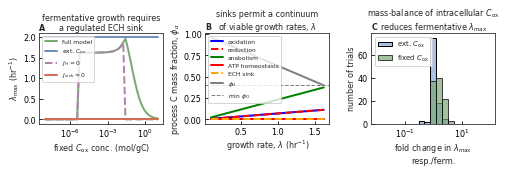

In [6]:
# Fermentation model results supplementary figure. 
mosaic = "ABC"
fig, axs = plt.subplot_mosaic(mosaic, figsize=(7.08, 2.5))

plt.sca(axs['A'])
plt.xscale('log')
model_order = 'ferm_full,ferm_full_ext_C,ferm_no_ATP_homeostasis,ferm_no_ECH_sink'.split(',')
color_order = ['green', 'blue', 'purple', 'red']
line_styles = ['-', '-', '--', '-']
for model, color_name, ls in zip(model_order, color_order, line_styles):
    mask = ferm_C_ox_df.model == model
    sns.lineplot(data=ferm_C_ox_df[mask], x='opt.fixed_C_ox_mol_gCDW', y='lambda_hr',
                 label=model_pretty_names[model], color=colors[color_name], ls=ls)
plt.ylabel('$\lambda_{\mathrm{max}}$ (hr$^{-1}$)')
plt.xlabel('fixed $C_{\mathrm{ox}}$ conc. (mol/gC)')
plt.legend(loc=2, fontsize=6)

plt.sca(axs['B'])
phi_pretty_names = {
    'oxidation_phi': 'oxidation',
    'reduction_phi': 'reduction',
    'anabolism_phi': 'anabolism',
    'ATP_homeostasis_phi': 'ATP homeostasis',
    'ECH_homeostasis_phi': 'ECH sink', 
    'phi_O': '$\phi_{\mathrm{O}}$', }
phi_colors = {
    'oxidation_phi': 'blue',
    'reduction_phi': 'red',
    'anabolism_phi': 'green',
    'ATP_homeostasis_phi': 'red',
    'ECH_homeostasis_phi': 'orange',
    'phi_O': 'grey'
}
dashies = {
    'oxidation_phi': '-',
    'reduction_phi': '--',
    'anabolism_phi': '-',
    'ATP_homeostasis_phi': '-',
    'ECH_homeostasis_phi': '--',
    'phi_O': '-'
}
for phi_col, phi_pretty_name in phi_pretty_names.items():
    ls = dashies[phi_col]
    color_name = phi_colors[phi_col]
    sns.lineplot(data=ferm_lambda_df, x='lambda_hr', y=phi_col,
                 color=color_name, ls=ls, 
                 label=phi_pretty_name)

plt.axhline(ferm_lambda_df.min_phi_O[0], 0, ferm_lambda_df.lambda_hr.max(), 
            ls='--', color='grey', lw=1, label='min $\phi_{\mathrm{O}}$')
plt.legend(loc=2, fontsize=6)
plt.ylabel(r'process C mass fraction, $\phi_{\alpha}$')
plt.xlabel(r'growth rate, $\lambda$ (hr$^{-1}$)')

plt.sca(axs['C'])
plt.xscale('log')

# Comparing fermentation and respiration growth rates in the absence of the C_ox constraint.
tmp_ferm = ferm_comp_C_ext_df.set_index('run_index')
tmp_resp = resp_comp_df.set_index('run_index')
fc = tmp_resp.lambda_hr / tmp_ferm.lambda_hr
print('Fold changes in absense of C_ox constraint')
print('lambda_max (resp/ferm) mean:', np.mean(fc))
print('lambda_max (resp/ferm) median:', np.median(fc))
print('lambda_max (resp/ferm) gmean:', gmean(fc))

plt.hist(fc, bins=np.logspace(-2, 2, 20), color=colors['light_blue'], edgecolor='k',
         label='ext. $C_{\mathrm{ox}}$')

# Comparing fermentation and respiration growth rates in the absence of the C_ox constraint
# but with more ATP from fermentation than above calculation
tmp_resp = resp_comp_df.set_index('run_index')
tmp_ferm = ferm_comp_ext_C_more_ATP_df.set_index('run_index')
fc_more_ATP = (tmp_resp.lambda_hr / tmp_ferm.lambda_hr)
print('Fold changes in absence of C_ox constraint, with more fermentative ATP')
print('lambda_max (resp/ferm) mean:', np.mean(fc_more_ATP))
print('lambda_max (resp/ferm) median:', np.median(fc_more_ATP))
print('lambda_max (resp/ferm) gmean:', gmean(fc_more_ATP))

# Comparing fermentation and respiration in the presence of mass balance constraint at C_ox = 1e-6
tmp_resp = resp_comp_df.set_index('run_index')
tmp_ferm = ferm_comp_one_C_ox_df.set_index('run_index')
fc_fixed_C_ox = tmp_resp.lambda_hr / tmp_ferm.lambda_hr
print('Fold changes in presence of C_ox constraint at C_ox = 1e-6')
print('lambda_max (resp/ferm) mean:', np.mean(fc_fixed_C_ox))
print('lambda_max (resp/ferm) median:', np.median(fc_fixed_C_ox))
print('lambda_max (resp/ferm) gmean:', gmean(fc_fixed_C_ox))

plt.hist(fc_fixed_C_ox, bins=np.logspace(-2, 2, 20), color=colors['green'], edgecolor='k',
         label='fixed $C_{\mathrm{ox}}$', alpha=0.7)


plt.legend(loc=2)
plt.xlabel('fold change in $\lambda_{\mathrm{max}}$\nresp./ferm.')
plt.ylabel('number of trials')

titles = {
    'A': 'fermentative growth requires\na regulated ECH sink',
    'B': 'sinks permit a continuum\nof viable growth rates, $\lambda$',
    'C': 'mass-balance of intracellular $C_{\mathrm{ox}}$\nreduces fermentative $\lambda_{\mathrm{max}}$'
}
for panel, title in titles.items():
    plt.sca(axs[panel])
    plt.title(panel, loc='left', fontweight='bold')
    plt.title(title, loc='center')

plt.tight_layout()
plt.savefig('../output/FigSX_fermentation_model.png', facecolor='white', dpi=300)
plt.show()